In [1]:
import findspark
findspark.init('/opt/spark/spark-3.3.0-bin-hadoop3')
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
import pyspark.sql.functions as F
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import DenseVector, VectorUDT,Vectors
from typing import Iterator
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType
import time
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler
from PIL import Image, ImageDraw
from tensorflow.keras.applications.resnet50 import ResNet50
import boto3
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from configparser import ConfigParser
import warnings
warnings.filterwarnings('ignore')


2022-10-09 15:37:06.900325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 15:37:07.433754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 15:37:07.433788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 15:37:07.494911: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 15:37:08.742846: W tensorflow/stream_executor/platform/defaul

In [2]:
spark = SparkSession.builder \
            .appName("my_app") \
            .getOrCreate()
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.InstanceProfileCredentialsProvider,com.amazonaws.auth.DefaultAWSCredentialsProviderChain")
spark._jsc.hadoopConfiguration().set("fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3A")

22/10/09 15:37:13 WARN Utils: Your hostname, ceyhun-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/10/09 15:37:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 15:37:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext.getOrCreate()

In [4]:
# Define S3 path
path_s3 = 's3a://openclassroom-p8-ceyhun/fruits_sample'
path_s3_root = 's3a://openclassroom-p8-ceyhun'


In [5]:
df_image = spark.read.format('image').load(f"{path_s3}/*")
df_image.show(5)

22/10/09 15:37:18 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+--------------------+
|               image|
+--------------------+
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
+--------------------+
only showing top 5 rows



In [6]:
spark = SparkSession(sc)

In [7]:
# Define S3 path
path_s3 = 's3a://openclassroom-p8-ceyhun/fruits_sample'
path_s3_root = 's3a://openclassroom-p8-ceyhun'

### Load the ResNet-50 Model and broadcast the weights.

In [8]:
model = ResNet50()
bc_model_weights = sc.broadcast(model.get_weights())

2022-10-09 15:37:34.262789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 15:37:34.263701: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 15:37:34.263731: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ceyhun-VirtualBox): /proc/driver/nvidia/version does not exist
2022-10-09 15:37:34.264516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import data

In [9]:


df_image.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [10]:
print(f"count of image = {df_image.count()} length of columns = {len(df_image.columns)}")


count of image = 13 length of columns = 1


### Converting all images in Spark

In [11]:
image_row = 7

In [12]:
schema = StructType(df_image.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T
    
def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=img_data.data, size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([224, 224], resample=Image.Resampling.BICUBIC) if (resize) else img
    arr = convert_bgr_array_to_rgb_array(np.asarray(img))
    arr = arr.reshape([224*224*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch

resized_df = df_image.select("image.*").mapInPandas(resize_image_udf, schema)

We can check if the data contains a converted and a resized image

In [13]:
row = resized_df.collect()[image_row]


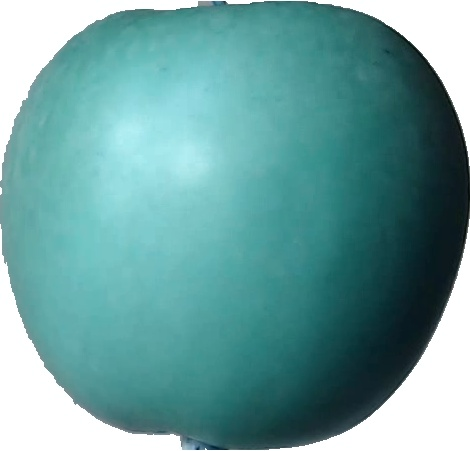

In [14]:
Image.frombytes(mode='RGB', data=bytes(row.data), size=[row.width,row.height])

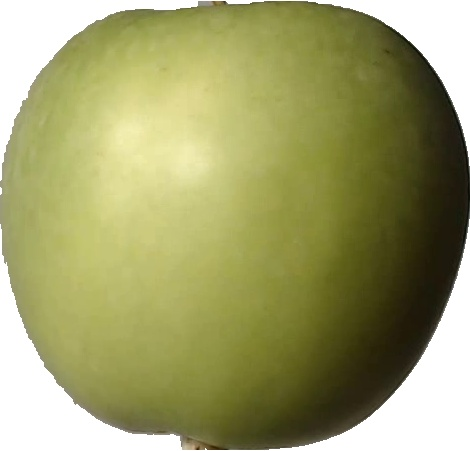

In [15]:
Image.frombytes(mode='RGB', data=bytes(row.data_as_array), size=[row.width,row.height])


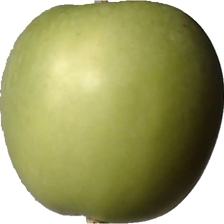

In [16]:

Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224])

### Predicting with the ResNet50 model

In [17]:
def normalize_array(arr):
    return tf.keras.applications.resnet50.preprocess_input(arr.reshape([224,224,3]))

@pandas_udf(ArrayType(FloatType()))
def predict_batch_udf(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = ResNet50(weights=None)
    model.set_weights(bc_model_weights.value)
    for input_array in iterator:
        normalized_input = np.stack(input_array.map(normalize_array))
        preds = model.predict(normalized_input)
        yield pd.Series(list(preds))

predicted_df = resized_df.withColumn("predictions", predict_batch_udf("data_as_resized_array"))


To check the prediction of our reference image

In [18]:
prediction_row = predicted_df.collect()[image_row]



2022-10-09 15:37:52.707226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 15:37:52.845051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 15:37:52.845305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 15:37:52.874622: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 15:37:54.084904: W tensorflow/stream_executor/platform/defaul

In [19]:
tf.keras.applications.resnet50.decode_predictions(
    np.array(prediction_row.predictions).reshape(1,1000), top=5
)

[[('n07742313', 'Granny_Smith', 0.9980723857879639),
  ('n07749582', 'lemon', 0.00036845251452177763),
  ('n04409515', 'tennis_ball', 0.00030365970451384783),
  ('n02782093', 'balloon', 0.00018677501066122204),
  ('n07753592', 'banana', 5.9041525673819706e-05)]]

### Get the top 5 predictions for every image

In [20]:
decoded_predictions_schema = StructType(predicted_df.schema.fields + [
    StructField("pred_id", ArrayType(StringType()), False),
    StructField("label", ArrayType(StringType()), False),
    StructField("score", ArrayType(FloatType()), False)
])

def top5_predictions(preds):
    return tf.keras.applications.resnet50.decode_predictions(
        np.array(preds).reshape(1,1000), top=5
    )

def top5predictions_batch_udf(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in iterator:
        yield pd.merge(
            dataframe_batch, 
            right=pd.concat([
                pd.DataFrame(top5, columns=["pred_id", "label", "score"]).aggregate(lambda x: [x.tolist()], axis=0) for [top5] in dataframe_batch.predictions.map(top5_predictions)
                ]).reset_index(drop=True),
            left_index=True,
            right_index=True
        )


In [21]:

top5_predictions_df = predicted_df.mapInPandas(top5predictions_batch_udf, decoded_predictions_schema)

In [22]:
top5_prediction = top5_predictions_df.collect()[image_row]


1/1 [==============================] - 2s 2s/step                   (0 + 1) / 1]
2022-10-09 15:38:12.160046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 15:38:12.471345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 15:38:12.471703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 15:38:12.546450: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been re

In [23]:
def image_with_label(image, label):
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), label, fill="red")
    return image



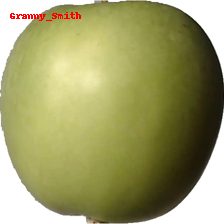

In [24]:
display(image_with_label(
    Image.frombytes(mode='RGB', data=bytes(top5_prediction.data_as_resized_array), size=[224,224]),
    top5_prediction.label[0]
))

1/1 [==============================] - 2s 2s/step                   (0 + 1) / 1]


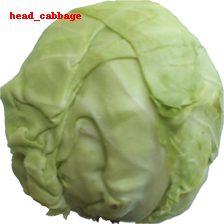

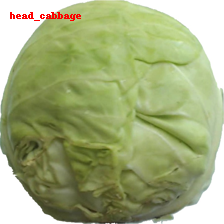

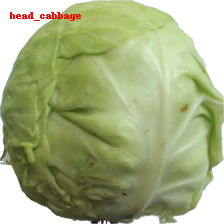

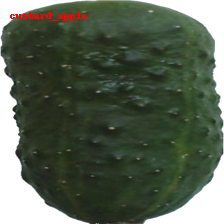

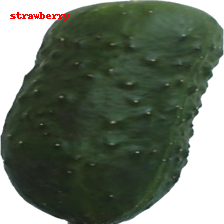

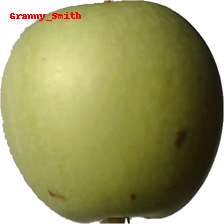

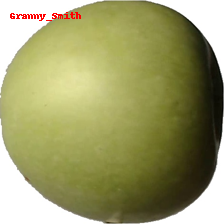

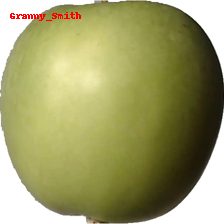

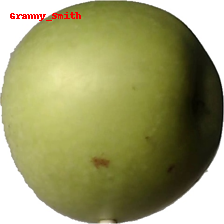

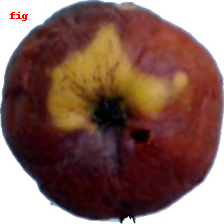

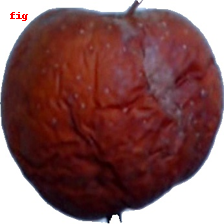

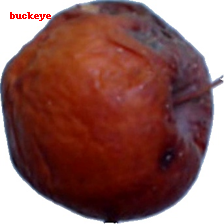

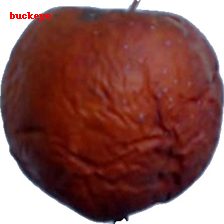

In [25]:
for row in top5_predictions_df.collect()[0:14]:
    display(image_with_label(
        Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]),
        row.label[0]
    ))

### PCA

In [26]:
df_image.show()

+--------------------+
|               image|
+--------------------+
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
|{s3a://openclassr...|
+--------------------+



In [27]:

def pca_transformation(df, n_components=2, col_image='image'):
    
    """
    Applique un algorithme de PCA sur l'ensemble des images pour réduire la dimension de chaque image 
    du jeu de données.
    
    Paramètres:
    df(pyspark dataFrame): contient une colonne avec les données images
    n_components(int): nombre de dimensions à conserver
    col_image(string): nom de la colonne où récupérer les données images
    """

    # Initilisation du temps de calcul
    start_time = time.time()

    # Les données images sont converties au format vecteur dense
    #ImageSchema.imageFields
    img2vec = F.udf(lambda x : Vectors.dense(x), VectorUDT())
    

    df = df.withColumn("data_as_vector", img2vec("data_as_resized_array"))

    standardizer = StandardScaler(withMean=True, withStd=True, inputCol="data_as_vector", outputCol="scaledFeatures")
 
    model_std = standardizer.fit(df)
    df = model_std.transform(df)
    # Entrainement de l'algorithme
    pca = PCA(k=n_components, inputCol='data_as_vector', outputCol='pcaFeatures')
    model_pca = pca.fit(df)

    # Transformation des images sur les k premières composantes
    df = model_pca.transform(df)

    df = df.filter(df.pcaFeatures.isNotNull())
    
    print(model_pca.explainedVariance)

    
    # Affiche le temps de calcul
    print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))
    
    

    return df

In [28]:
print("---Réduction dimensionnelle---")
df = pca_transformation(resized_df)
df.show(5)

---Réduction dimensionnelle---


22/10/09 15:38:56 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB


22/10/09 15:39:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/09 15:39:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/09 15:39:02 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/10/09 15:39:02 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK
22/10/09 15:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/09 15:39:09 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


22/10/09 15:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:21 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:39 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:47 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:40:55 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:41:03 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB


22/10/09 15:41:29 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.
[0.637414597351154,0.36258540264884603]
Temps d'execution 173.47 secondes
22/10/09 15:41:29 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|              origin|height|width|nChannels|mode|                data|data_as_resized_array|       data_as_array|      data_as_vector|      scaledFeatures|         pcaFeatures|
+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|s3a://openclassro...|   744|  778|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|[-36292.775883125...|
|s3a://openclassro...|   706|  722|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|[-33814.861621121...|
|s3a://openclassro...|   705|  741|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2

In [29]:
df = df.withColumn('label',F.split(F.split('origin', '//').getItem(1),'/').getItem(2), )

In [30]:
df = df.withColumn('img_path_s3',F.split(F.col('origin'), 's3a://')[1])

In [31]:
df.show(3)

22/10/09 15:42:07 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+
|              origin|height|width|nChannels|mode|                data|data_as_resized_array|       data_as_array|      data_as_vector|      scaledFeatures|         pcaFeatures|          label|         img_path_s3|
+--------------------+------+-----+---------+----+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+
|s3a://openclassro...|   744|  778|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|[255.0,255.0,255....|[0.0,0.0,0.0,0.0,...|[-36292.775883125...|cabbage_white_1|openclassroom-p8-...|
|s3a://openclassro...|   706|  722|        3|  16|[FF FF FF FF FF F...| [255, 255, 255, 2...|[255, 255, 255, 2...|[255.0,255.0,255....|[0.0,

### Save Files as Parquet

In [32]:
result_df = df.select('img_path_s3','pcaFeatures', 'label')
result_df.show()


22/10/09 15:42:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+--------------------+--------------------+--------------------+
|         img_path_s3|         pcaFeatures|               label|
+--------------------+--------------------+--------------------+
|openclassroom-p8-...|[-36292.775883125...|     cabbage_white_1|
|openclassroom-p8-...|[-33814.861621121...|     cabbage_white_1|
|openclassroom-p8-...|[-34564.791956497...|     cabbage_white_1|
|openclassroom-p8-...|[-11680.891318570...|          cucumber_1|
|openclassroom-p8-...|[-10799.869759969...|          cucumber_1|
|openclassroom-p8-...|[-38651.840423738...|apple_granny_smith_1|
|openclassroom-p8-...|[-40391.651082526...|apple_granny_smith_1|
|openclassroom-p8-...|[-39437.741593447...|apple_granny_smith_1|
|openclassroom-p8-...|[-36272.882319034...|apple_granny_smith_1|
|openclassroom-p8-...|[-12509.175459769...|      apple_rotten_1|
|openclassroom-p8-...|[-8275.7465326340...|      apple_rotten_1|
|openclassroom-p8-...|[-11691.208398820...|      apple_rotten_1|
|openclassroom-p8-...|[-9

In [33]:
result_df.write.mode("overwrite").parquet(f'{path_s3_root}/ACP_result_parquet')

22/10/09 15:43:07 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [34]:
result_df = spark.read.parquet(f'{path_s3_root}/ACP_result_parquet')
result_df.show(3)

+--------------------+--------------------+---------------+
|         img_path_s3|         pcaFeatures|          label|
+--------------------+--------------------+---------------+
|openclassroom-p8-...|[-36292.775883125...|cabbage_white_1|
|openclassroom-p8-...|[-33814.861621121...|cabbage_white_1|
|openclassroom-p8-...|[-34564.791956497...|cabbage_white_1|
+--------------------+--------------------+---------------+
only showing top 3 rows

